### Investigating network similarity for the analysis of fish behaviour

In [64]:
import os
import numpy as np
import netrd, networkx as nx
import statistics
import pandas as pd
import itertools
import matplotlib.pyplot as plt


"""
lists directory, each element with its full path
"""
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]


"""
Returns Jaccard distance for weighted directed networks 
"""
def weighted_jaccard(g1,g2):
    e1 = set(g1.edges)
    e2 = set(g2.edges)
    cup = set.union(e1, e2)
    cap = set.intersection(e1, e2)

    #if edge weights are different only add the relative accordance
    relative_sum = 0
    for edge in cap:
        w1 = g1.get_edge_data(edge[0], edge[1])["label"]
        w2 = g2.get_edge_data(edge[0], edge[1])["label"]
        if w1 > w2:
            relative_sum = relative_sum + (w2 / w1)
        elif w2 > w1:
            relative_sum = relative_sum + (w1 / w2)
        else:
            relative_sum = relative_sum +1

    dist = 1 - relative_sum / len(cup)
    return dist


#lists with the files
oce_bvr = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/ocellatus-behaviours/")
mul_bvr = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/multi-behaviours/")
tem_bvr = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/tempo-behaviours/")

oce_ctg = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/ocellatus-categories/")
mul_ctg = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/multi-categories/")
tem_ctg = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/tempo-categories/")

behaviours = [oce_bvr, mul_bvr, tem_bvr]
categories = [oce_ctg, mul_ctg, tem_ctg]

# list with algorithms to apply
distance_algs =  [netrd.distance.DeltaCon(), 
                  netrd.distance.Hamming(),
                  netrd.distance.Frobenius(),
                  netrd.distance.PortraitDivergence(),
                  netrd.distance.JaccardDistance(), 
                  'weighted_jaccard',
]
#distance_algs = [netrd.distance.DeltaCon()]
#names 
algs = ['deltacon', 'hamming', 'frobenius', 'portrait_divergence', 
        'jaccard_distance', 'weighted_jaccard']
#algs = ['deltacon']
#istance_algs = [netrd.distance.PortraitDivergence()]
same_nodes_algs = ['hamming', 'frobenius', 'deltacon']

results= []
df = pd.DataFrame(columns=['alg', 'data1', 'data2', 'results'])
general_df = pd.DataFrame(columns=['alg', 'data', 'type', 'results'])

for alg in distance_algs:
    if alg == 'weighted_jaccard':
        alg_name = alg
    else:
        alg_name = str(alg).split(".")[2]
    print(alg_name)
    
    #lists for specieal results
    bhvr_across_species = []
    bhvr_within_species = []
    cat_across_species = []
    cat_within_species = []
    
    #BEHAVIOURS PAIRWISE
    for data1, data2 in itertools.combinations(behaviours, 2):
        #folder names for adding in dataframe
        folder1 = str(data1).split("/")[6]
        folder2 = str(data2).split("/")[6]
        #compare each folder with each other
        for a in data1:
            for b in data2:

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)

                # if alg requires same nodeset, add nodes
                if alg_name in same_nodes_algs:    
                    not_in_g1 = np.setdiff1d(g2.nodes(),g1.nodes())
                    g1.add_nodes_from(not_in_g1)
                    not_in_g2 = np.setdiff1d(g1.nodes(),g2.nodes())
                    g2.add_nodes_from(not_in_g2)

                #calculate and append results
                if alg_name == 'weighted_jaccard':
                    results.append(weighted_jaccard(g1,g2))
                else:
                    dist = alg
                    d = dist.dist(g1, g2)
                    results.append(d)
               


        #calculate statistics and append to across species list
        df.loc[len(df.index)] = [alg_name,folder1, folder2, results]
        bhvr_across_species.extend(results)
        results = []
        
    #add row for behaviours across species
    general_df.loc[len(df.index)] = [alg_name, 'across species', 'behaviours', bhvr_across_species]    
        
        
    #CATEGORIES PAIRWISE
    for data1, data2 in itertools.combinations(categories, 2):
        #folder names for adding in dataframe
        folder1 = str(data1).split("/")[6]
        folder2 = str(data2).split("/")[6]
        #compare each folder with each other
        for a in data1:
            for b in data2:

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)

                # if alg requires same nodeset, add nodes
                if alg_name in same_nodes_algs:    
                    not_in_g1 = np.setdiff1d(g2.nodes(),g1.nodes())
                    g1.add_nodes_from(not_in_g1)
                    not_in_g2 = np.setdiff1d(g1.nodes(),g2.nodes())
                    g2.add_nodes_from(not_in_g2)

               
                #calculate and append results
                if alg_name == 'weighted_jaccard':
                    results.append(weighted_jaccard(g1,g2))
                else:
                    dist = alg
                    d = dist.dist(g1, g2)
                    results.append(d)
                
        #calculate statistics
        df.loc[len(df.index)] = [alg_name,folder1, folder2, results]
        cat_across_species.extend(results)
        results = []
        
    #add row for behaviours across species
    general_df.loc[len(df.index)] = [alg_name, 'across species', 'behavioural category', cat_across_species]  
        
    #CATEGORIES SINGLE
    for data in categories:
        #folder names for adding in dataframe
        folder1 = str(data).split("/")[6]
        folder2 = str(data).split("/")[6]
        #compare each folder with each other
        for a,b in itertools.combinations(data, 2):

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)

                # if alg requires same nodeset, add nodes
                if alg_name in same_nodes_algs:    
                    not_in_g1 = np.setdiff1d(g2.nodes(),g1.nodes())
                    g1.add_nodes_from(not_in_g1)
                    not_in_g2 = np.setdiff1d(g1.nodes(),g2.nodes())
                    g2.add_nodes_from(not_in_g2)

                
                #calculate and append results
                if alg_name == 'weighted_jaccard':
                    results.append(weighted_jaccard(g1,g2))
                else:
                    dist = alg
                    d = dist.dist(g1, g2)
                    results.append(d)

        #calculate statistics
        df.loc[len(df.index)] = [alg_name,folder1, folder2, results]
        cat_within_species.extend(results)
        results = []
        
    #add row for behaviours across species
    general_df.loc[len(df.index)] = [alg_name, 'within species', 'behavioural category', cat_within_species]  
        
        
    #BEHAVIOURS SINGLE
    for data in behaviours:
        #folder names for adding in dataframe
        folder1 = str(data).split("/")[6]
        folder2 = str(data).split("/")[6]
        #compare each folder with each other
        for a,b in itertools.combinations(data, 2):

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)

                # if alg requires same nodeset, add nodes
                if alg_name in same_nodes_algs:    
                    not_in_g1 = np.setdiff1d(g2.nodes(),g1.nodes())
                    g1.add_nodes_from(not_in_g1)
                    not_in_g2 = np.setdiff1d(g1.nodes(),g2.nodes())
                    g2.add_nodes_from(not_in_g2)

               
                #calculate and append results
                if alg_name == 'weighted_jaccard':
                    results.append(weighted_jaccard(g1,g2))
                else:
                    dist = alg
                    d = dist.dist(g1, g2)
                    results.append(d)

        #calculate statistics
        df.loc[len(df.index)] = [alg_name,folder1, folder2, results]
        bhvr_within_species.extend(results)
        results = []
        
    #add row for behaviours across species
    general_df.loc[len(df.index)] = [alg_name, 'within species', 'behaviours', bhvr_within_species] 


deltacon
hamming
frobenius
portrait_divergence
jaccard_distance
weighted_jaccard
dk_series


ValueError: row index exceeds matrix dimensions

In [59]:
df

,alg,data1,data2,results
0,deltacon,ocellatus-behaviours,multi-behaviours,"[2.687838714816187, 2.1551566857478925, 3.1879..."
1,deltacon,ocellatus-behaviours,tempo-behaviours,"[2.683636567317491, 2.3428786601921696, 2.3728..."
2,deltacon,multi-behaviours,tempo-behaviours,"[3.4832396688003673, 2.2427754023167834, 2.558..."
3,deltacon,ocellatus-categories,multi-categories,"[1.4039680243155717, 0.9552118351021708, 2.193..."
4,deltacon,ocellatus-categories,tempo-categories,"[2.10594898685723, 1.1975366282350515, 1.54108..."
...,...,...,...,...
79,quantum_jsd,multi-categories,multi-categories,"[0.07719705757850177, 0.11119675545035698, 0.0..."
80,quantum_jsd,tempo-categories,tempo-categories,"[0.09121946119123478, 0.07394449024323374, 0.0..."
81,quantum_jsd,ocellatus-behaviours,ocellatus-behaviours,"[0.14078603823977331, 0.10687127650252896, 0.1..."
82,quantum_jsd,multi-behaviours,multi-behaviours,"[0.14817150029037893, 0.17233991425570164, 0.1..."


In [60]:
# add new column 'type' and remove type from data-columns
df['type'] = df.data1

#changing type 
type_mapping = [
    (df['type'] == 'multi-categories', 'behavioural category'),
    (df['type'] == 'tempo-categories', 'behavioural category'),
    (df['type'] == 'ocellatus-categories', 'behavioural category'),
    
    (df['type'] == 'ocellatus-behaviours', 'behaviour'),
    (df['type'] == 'multi-behaviours', 'behaviour'),
    (df['type'] == 'tempo-behaviours', 'behaviour'),
]
condlist = [item[0] for item in type_mapping]
choicelist = [item[1] for item in type_mapping]


df['type'] = np.select(condlist, choicelist)

#changing data column
data1_mapping = [
    (df['data1'] == 'multi-categories', 'multi'),
    (df['data1'] == 'tempo-categories', 'tempo'),
    (df['data1'] == 'ocellatus-categories', 'oclts'),
    
    (df['data1'] == 'ocellatus-behaviours', 'oclts'),
    (df['data1'] == 'multi-behaviours', 'multi'),
    (df['data1'] == 'tempo-behaviours', 'tempo'),
]
condlist = [item[0] for item in data1_mapping]
choicelist = [item[1] for item in data1_mapping]


df['data1'] = np.select(condlist, choicelist)

#changing data2 column
data1_mapping = [
    (df['data2'] == 'multi-categories', 'multi'),
    (df['data2'] == 'tempo-categories', 'tempo'),
    (df['data2'] == 'ocellatus-categories', 'oclts'),
    
    (df['data2'] == 'ocellatus-behaviours', 'oclts'),
    (df['data2'] == 'multi-behaviours', 'multi'),
    (df['data2'] == 'tempo-behaviours', 'tempo'),
]
condlist = [item[0] for item in data1_mapping]
choicelist = [item[1] for item in data1_mapping]


df['data2'] = np.select(condlist, choicelist)
df

,alg,data1,data2,results,type
0,deltacon,oclts,multi,"[2.687838714816187, 2.1551566857478925, 3.1879...",behaviour
1,deltacon,oclts,tempo,"[2.683636567317491, 2.3428786601921696, 2.3728...",behaviour
2,deltacon,multi,tempo,"[3.4832396688003673, 2.2427754023167834, 2.558...",behaviour
3,deltacon,oclts,multi,"[1.4039680243155717, 0.9552118351021708, 2.193...",behavioural category
4,deltacon,oclts,tempo,"[2.10594898685723, 1.1975366282350515, 1.54108...",behavioural category
...,...,...,...,...,...
79,quantum_jsd,multi,multi,"[0.07719705757850177, 0.11119675545035698, 0.0...",behavioural category
80,quantum_jsd,tempo,tempo,"[0.09121946119123478, 0.07394449024323374, 0.0...",behavioural category
81,quantum_jsd,oclts,oclts,"[0.14078603823977331, 0.10687127650252896, 0.1...",behaviour
82,quantum_jsd,multi,multi,"[0.14817150029037893, 0.17233991425570164, 0.1...",behaviour


### plots
erste zeile ist titel, 
2te (2te und 3te) sind x-achsenabschnitte,
median,max,min sind spritzen-y-gemappt


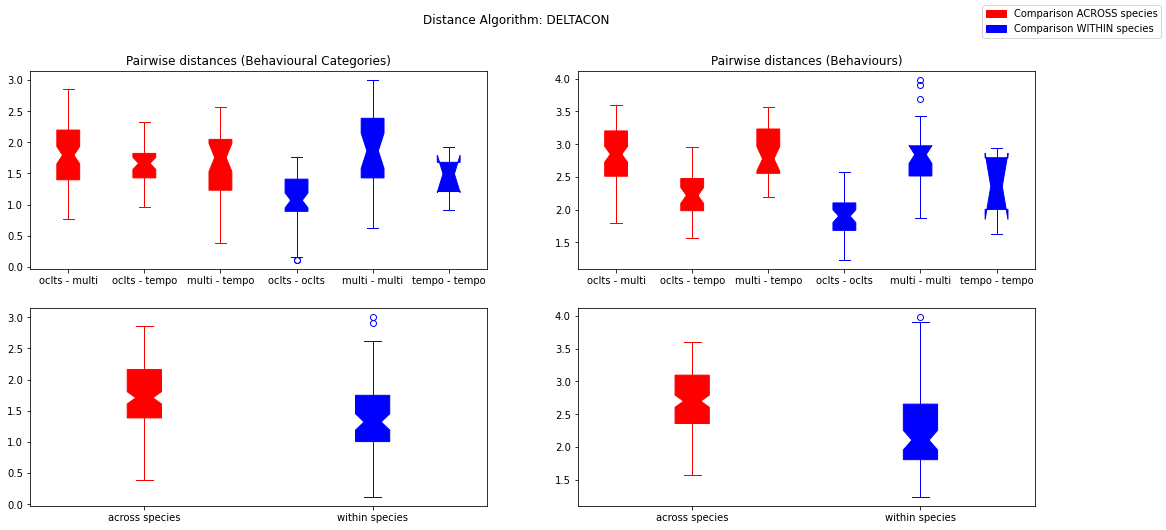

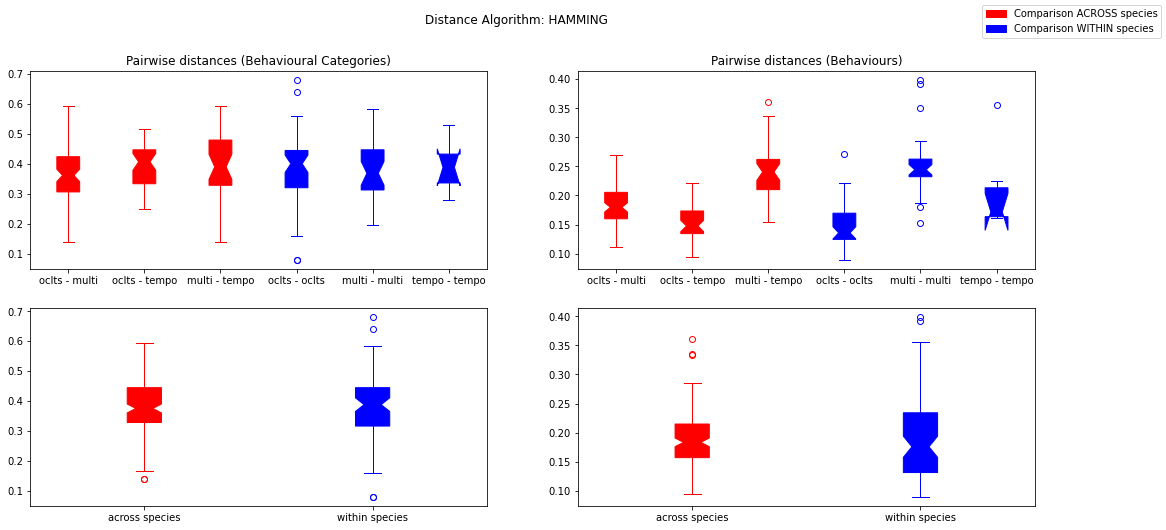

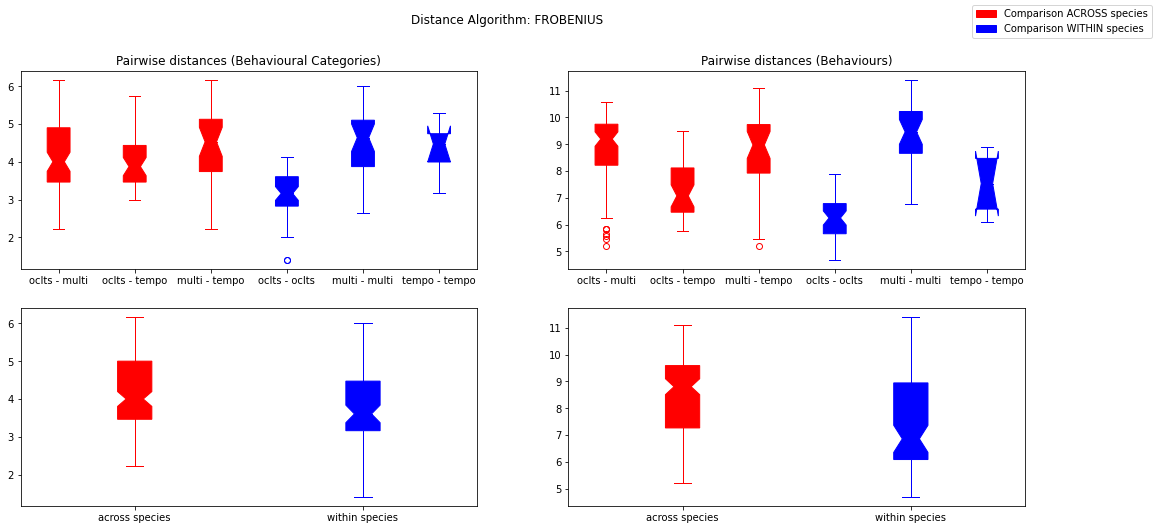

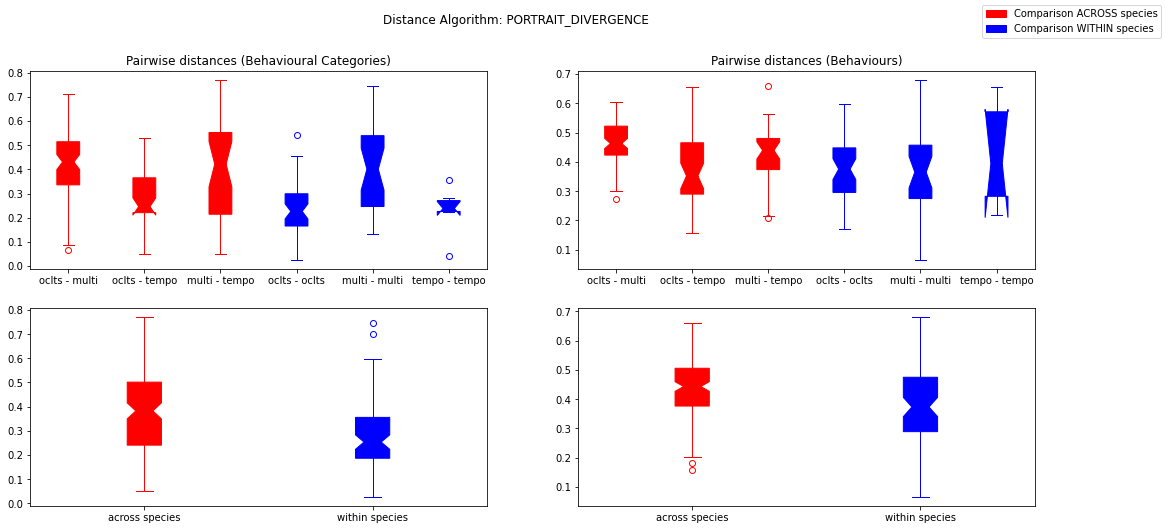

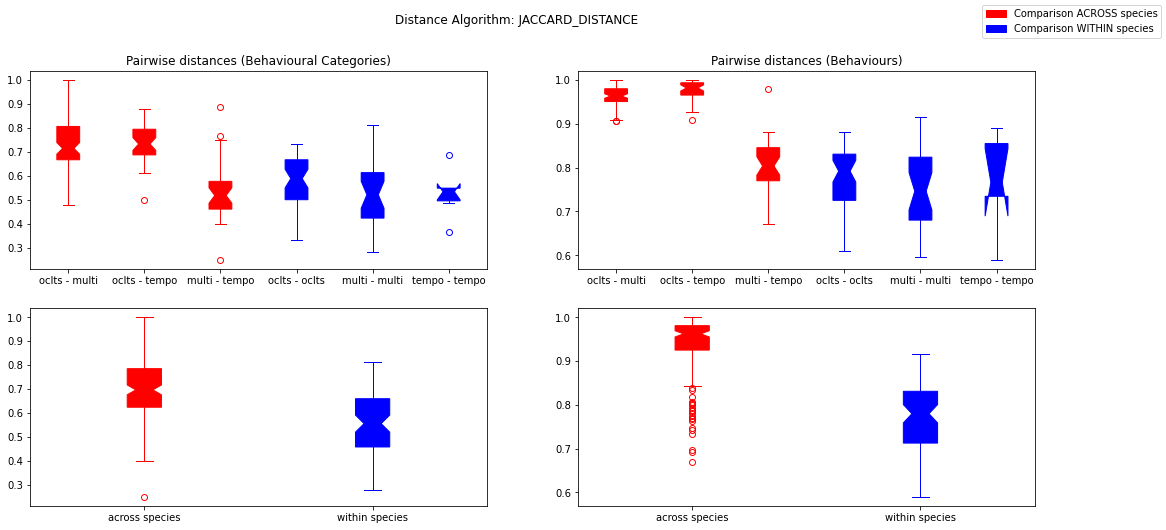

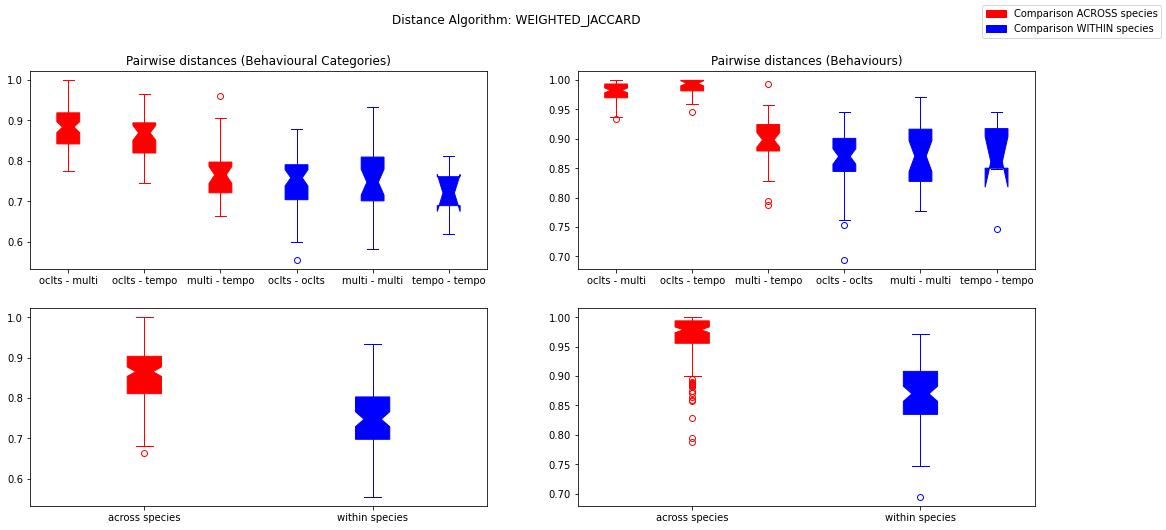

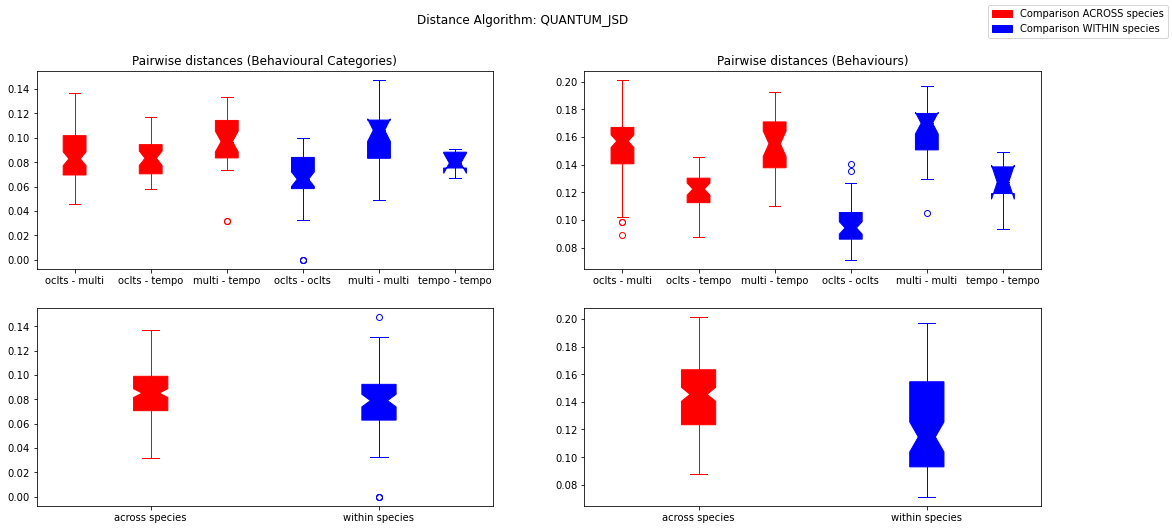

In [61]:
import matplotlib.patches as mpatches


for alg in algs:
    alg_df = df[df.alg == alg]
    
    #behavioural category data gen
    bhvr_df = alg_df[alg_df.type == 'behavioural category']
    data = []
    labels = []
    i=0
    while (i < len(bhvr_df)):
        data.append(bhvr_df.iloc[i]['results'])
        labels.append(bhvr_df.iloc[i]['data1'] + " - " +bhvr_df.iloc[i]['data2'])
        i = i+1
        
    #behaviour data gen
    bhvr_df = alg_df[alg_df.type == 'behaviour']
    data_bhvr = []
    labels_bhvr = []
    i=0
    while (i < len(bhvr_df)):
        data_bhvr.append(bhvr_df.iloc[i]['results'])
        labels_bhvr.append(bhvr_df.iloc[i]['data1'] + " - " +bhvr_df.iloc[i]['data2'])
        i = i+1
        
       
    #behavioural category plot
    c = 'red'
    fig, axs = plt.subplots(2,2, figsize=(18,8))
    axs[0,0].boxplot(data[:3], positions=[1,2,3], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    c='blue'
    axs[0,0].boxplot(data[3:], positions=[4,5,6], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    axs[0,0].set_title('Pairwise distances (Behavioural Categories)')
    axs[0,0].set_xticklabels(labels)
    
    #behaviour plot
    c = 'red'
    axs[0,1].boxplot(data_bhvr[:3], positions=[1,2,3], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    c='blue'
    axs[0,1].boxplot(data_bhvr[3:], positions=[4,5,6], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            
            )
    axs[0,1].set_title('Pairwise distances (Behaviours)')
    axs[0,1].set_xticklabels(labels_bhvr)
    
    #title
    fig.suptitle("Distance Algorithm: " + alg.upper())
    
    
    
    
    
# generalized data plots below normal data

    alg_df = general_df[general_df.alg == alg]

    #behavioural category data gen
    bhvr_df = alg_df[alg_df.type == 'behavioural category']
    data = []
    labels = []
    i=0
    while (i < len(bhvr_df)):
        data.append(bhvr_df.iloc[i]['results'])
        labels.append(bhvr_df.iloc[i]['data'])
        i = i+1

    #behaviour data gen
    bhvr_df = alg_df[alg_df.type == 'behaviours']
    data_bhvr = []
    labels_bhvr = []
    i=0
    while (i < len(bhvr_df)):
        data_bhvr.append(bhvr_df.iloc[i]['results'])
        labels_bhvr.append(bhvr_df.iloc[i]['data'])
        i = i+1

       
    #behavioural category plot
    c = 'red'
    axs[1,0].boxplot(data[:1], positions=[1], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    c='blue'
    axs[1,0].boxplot(data[1:], positions=[2], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    axs[1,0].set_xticklabels(labels)
    
    
    #general behaviour plot
    c = 'red'
    axs[1,1].boxplot(data_bhvr[:1], positions=[1], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    c='blue'
    axs[1,1].boxplot(data_bhvr[1:], positions=[2], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
   
    axs[1,1].set_xticklabels(labels_bhvr)

    
    
    
    # Adding title and legend
    red_patch = mpatches.Patch(color='red', label='Comparison ACROSS species')
    blue_patch = mpatches.Patch(color='blue', label='Comparison WITHIN species')
    fig.legend(handles=[red_patch, blue_patch])
    # show plot
    plt.show()
    



# weighted jaccard

- edge label auf edge mappen
- kleineren durch größeren teilen, dann schnittmenge dementsprechend verkleinern

In [49]:
"""
Returns Jaccard distance for weighted directed networks 
"""
def weighted_jaccard(g1,g2):
    e1 = set(g1.edges)
    e2 = set(g2.edges)
    cup = set.union(e1, e2)
    cap = set.intersection(e1, e2)

    #if edge weights are different only add the relative accordance
    relative_sum = 0
    for edge in cap:

        w1 = g1.get_edge_data(edge[0], edge[1])["label"]
        w2 = g2.get_edge_data(edge[0], edge[1])["label"]
        if w1 > w2:
            relative_sum = relative_sum + (w2 / w1)
        elif w2 > w1:
            relative_sum = relative_sum + (w1 / w2)
        else:
            relative_sum = relative_sum +1

    dist = 1 - relative_sum / len(cup)
    return dist
    
g1 = nx.read_gpickle("/Users/nicol/Desktop/bachelorthesis/data/multi-categories/Multi_12_10_17_a2_first_15_02_19.gpickle")
g2 = nx.read_gpickle("/Users/nicol/Desktop/bachelorthesis/data/multi-categories/Multi_12_10_17_e1_first_19_02_19.gpickle")

dist = weighted_jaccard(g1,g2)
dist

('Maintenance', 'Escape')
10 10 1
('Maintenance', 'Submissive behavior')
2 1 1.5
('Maintenance', 'Maintenance')
17 127 1.6338582677165354
('Escape', 'Escape')
11 3 1.9065855404438081
('Escape', 'Maintenance')
6 11 2.4520400858983535
('Submissive behavior', 'Maintenance')
3 1 2.785373419231687
2.785373419231687 22


0.8733921173076507

In [ ]:
import time

#GED not working, laptop is failing

results= []
networkx_algs = ['ged']
for alg in networkx_algs:
    alg_name = alg
    
    #BEHAVIOURS PAIRWISE
    for data1, data2 in itertools.combinations(behaviours, 2):
        #folder names for adding in dataframe
        folder1 = str(data1).split("/")[6]
        folder2 = str(data2).split("/")[6]
        #compare each folder with each other
        for a in data1:
            for b in data2:

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)

                #networkx optimized function for graph edit distance
                timeout = time.time() + 5
                for v in nx.optimize_graph_edit_distance(g1, g2):
                    minv = v
                    print(time.time())
                    if time.time() > timeout:
                        break
                results.append(minv)
                print(minv)


        #calculate statistics
        df.loc[len(df.index)] = [alg_name,folder1, folder2, results]
        results = []
        
        
df






    


1625571534.515915
1625571534.523912
1625571534.551911
1625571535.5079672
1625571545.265967
33.0
1625571545.2779996
1625571545.2979636
1625571545.930006
1625571545.9422467
1625571548.6392412
1625571548.6552415
1625571555.4129596
43.0
1625571555.4194965
1625571555.4351223
1625571556.2152314
1625571559.9429808
1625571561.3319411
85.0
1625571561.3500252
1625571561.360102
1625571561.4125695
1625571572.0772448
40.0
1625571572.0929024
1625571572.139765
1625571572.3402808
1625571572.8104925
1625571574.3835266
